## First try at getting some data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re
import datetime as dt
import time as t
from termcolor import colored

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from  statsmodels.graphics.tsaplots import plot_pacf

#Time series
# from fbprophet import Prophet

#Regression imports
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection as f_select
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve


#Nice to have
from sklearn.pipeline import make_pipeline

#Geography magic
import geocoder
# import googlemaps
import geopy.distance as gd
import geopandas as gpd
import shapely
from shapely.geometry import Point

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 6
rcParams.update({'font.size': 14})

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load all the data into an SQL database

In [5]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [58]:
# taxi_rides_query = """SELECT * FROM taxi_rides WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 
# weather_query = """SELECT * FROM chicago_weather WHERE date BETWEEN '2016-02-01' AND '2016-02-15';"""

taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                --TR.pickup_community_area,
                                --TR.dropoff_community_area,
                                --TR.fare,
                                --TR.tolls,
                                CASE WHEN TR.tolls IS NULL THEN TR.fare ELSE TR.fare + TR.tolls END as fare_with_tolls,
                                --TR.tips,
                                --TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END as fog,
                                CASE WHEN CW.rain = 1 OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END as rain,
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END as snow
                                
                        FROM taxi_rides_clean as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2017-01-01' AND '2017-02-28'
                        ORDER BY TR.trip_start_timestamp DESC;""" 

In [59]:
#approx. 30min to load the whole of 2016 data
sql_load = pd.read_sql_query(taxi_weather_query, con=conn)

In [60]:
train_set_jan = sql_load[(sql_load['trip_start_timestamp'] >= '2017-01-01 00:00:00') & 
                         (sql_load['trip_start_timestamp'] < '2017-01-31 23:59:59')]

test_set_feb = sql_load[(sql_load['trip_start_timestamp'] >= '2017-02-01 00:00:00') & 
                         (sql_load['trip_start_timestamp'] < '2017-02-28 23:59:59')]

In [61]:
# taxi_weather_df = sql_load
# taxi_weather_df = sql_load[sql_load['trip_start_timestamp'] <= '2016-12-31 23:59:59']
# test_set_jan = sql_load[(sql_load['trip_start_timestamp'] >= '2017-01-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-01-31 23:59:59')]
# test_set_feb = sql_load[(sql_load['trip_start_timestamp'] >= '2017-02-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-02-28 23:59:59')]
# test_set_mar = sql_load[(sql_load['trip_start_timestamp'] >= '2017-03-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]
# test_set_apr = sql_load[(sql_load['trip_start_timestamp'] >= '2017-04-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-04-30 23:59:59')]
# test_set_may = sql_load[(sql_load['trip_start_timestamp'] >= '2017-05-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]
# test_set_jun = sql_load[(sql_load['trip_start_timestamp'] >= '2017-06-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-06-30 23:59:59')]
# test_set_jul = sql_load[(sql_load['trip_start_timestamp'] >= '2017-07-01 00:00:00') & (sql_load['trip_start_timestamp'] < '2017-03-31 23:59:59')]

In [62]:
# taxi_weather_df = sql_load.sample(n=75000, random_state=42)

In [63]:
train_set_jan.describe()

,trip_seconds,trip_miles,fare_with_tolls,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
count,1.040186e+06,1.040255e+06,1.040255e+06,943841.000000,943841.000000,925096.000000,925096.000000,1.040262e+06,1.040262e+06,1.040262e+06,1040262.0,1040262.0
mean,7.165514e+02,2.962954e+00,1.294192e+01,41.900391,-87.659718,41.900507,-87.651721,1.042192e+01,2.871399e+01,6.722124e-01,0.0,0.0
std,1.104101e+03,5.276065e+00,3.482515e+01,0.036941,0.074813,0.036213,0.054588,4.148031e+00,1.078390e+01,4.694072e-01,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,41.660136,-87.913625,41.660136,-87.913625,2.240000e+00,4.000000e+00,0.000000e+00,0.0,0.0
25%,3.000000e+02,4.000000e-01,6.000000e+00,41.880994,-87.651311,41.880994,-87.655998,7.160000e+00,2.200000e+01,0.000000e+00,0.0,0.0
50%,5.180000e+02,1.100000e+00,7.750000e+00,41.892042,-87.632746,41.892508,-87.633308,1.007000e+01,3.200000e+01,1.000000e+00,0.0,0.0
75%,8.400000e+02,2.570000e+00,1.275000e+01,41.901207,-87.626211,41.907520,-87.626215,1.275000e+01,3.700000e+01,1.000000e+00,0.0,0.0
max,8.634000e+04,1.234000e+03,9.000800e+03,42.015934,-87.534903,42.016046,-87.534903,2.326000e+01,4.800000e+01,1.000000e+00,0.0,0.0


> Original number of records for the whole of 2017 Jan: **943,841**

## Sweeping time!

In [64]:
#Change payment type to boolean
train_set_jan['payment_type'] = pd.Categorical(train_set_jan['payment_type'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
#Let's drop all the records with a missing lat / long in either pickup or dropoff
train_set_jan = train_set_jan.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude'
                                                    , 'dropoff_centroid_longitude', 'trip_seconds', 'trip_miles', 'fare_with_tolls'])

In [66]:
train_set_jan.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
977133,2017-01-31 23:45:00,2017-01-31 23:45:00,300.0,0.9,6.00,Cash,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),15.66,36,1,0,0
977134,2017-01-31 23:45:00,2017-01-31 23:45:00,120.0,0.4,4.25,Credit Card,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),15.66,36,1,0,0


In [67]:
train_set_jan[['fog', 'rain', 'snow']] = train_set_jan[['fog', 'rain', 'snow']].fillna(value=0)

In [68]:
#Let's get rid of the zeroes
train_set_jan = train_set_jan[(train_set_jan['fare_with_tolls'] != 0.0) 
                                          & (train_set_jan['trip_seconds'] != 0.0) 
                                          & (train_set_jan['trip_miles'] != 0.0)]

In [69]:
#Removing clear error records from the dataset (e.g. $1,000 for 0.1 mile and 6 min ride). Settling at max 100 miles an hour
train_set_jan = train_set_jan[(train_set_jan['trip_miles'] / (train_set_jan['trip_seconds'] / 3600.0)) <= 100.0]

In [70]:
#Based on above analysis, I'm setting a max fare/mile at $250 and max fare/minute to $50
train_set_jan = train_set_jan[((train_set_jan['fare_with_tolls'] / train_set_jan['trip_miles']) <= 50) &
                                 ((train_set_jan['fare_with_tolls'] / (train_set_jan['trip_seconds'] / 60.0)) <= 250)]

In [71]:
train_set_jan.count()[0]

717178

> Remaining number of records after cleaning for 2016: **76%** (717,178)

## Predicting the demand

In [153]:
with open('LinearRegression_demand.pkl', 'rb') as pickle_LinReg:
    LR_demand = pickle.load(pickle_LinReg)

In [154]:
#Define the start and end date and time
start = train_set_jan['trip_start_timestamp'].min()
end = train_set_jan['trip_start_timestamp'].max()

In [74]:
historic_demand_diff = get_diffed_demand(get_demand(start, end)) 

In [75]:
historic_demand_diff.head()

,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
trip_start_timestamp,,,,,,,,,
2017-01-08 00:15:00,32.0,4.0,-2.0,-57.0,35.0,28.0,-38.0,-18.0,135.0
2017-01-08 00:30:00,-92.0,32.0,4.0,-2.0,-57.0,35.0,28.0,1.0,24.0
2017-01-08 00:45:00,23.0,-92.0,32.0,4.0,-2.0,-57.0,35.0,-6.0,-37.0
2017-01-08 01:00:00,5.0,23.0,-92.0,32.0,4.0,-2.0,-57.0,-38.0,-5.0
2017-01-08 01:15:00,24.0,5.0,23.0,-92.0,32.0,4.0,-2.0,82.0,242.0


In [76]:
predicted_demand_jan = LR_demand.predict(historic_demand_diff)

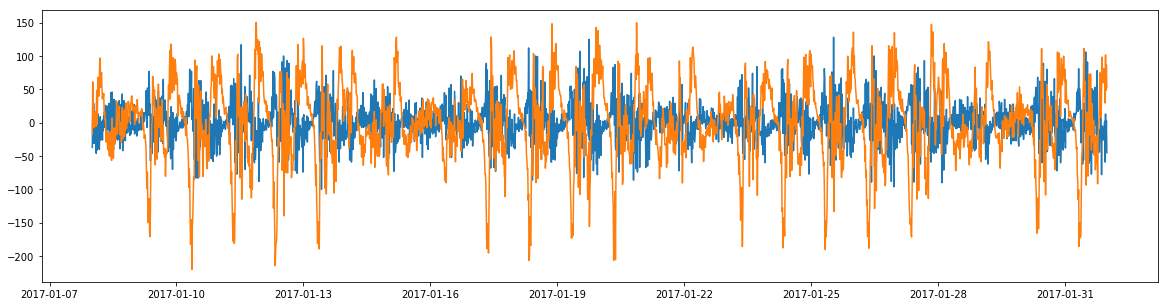

In [157]:
plt.figure(figsize=(20, 5))
plt.plot(historic_demand_diff.index, actual_jan_demand_diff)
plt.plot(historic_demand_diff.index, predicted_demand_jan);

> What the F***!!!

In [144]:
actual_jan_demand = train_set_jan.groupby(['trip_start_timestamp'])['trip_start_timestamp'].count()
actual_jan_demand_diff = actual_jan_demand.diff()[1:]
actual_jan_demand_diff = actual_jan_demand_diff[672:]

In [145]:
print('RMSE is', str(round(np.sqrt(mean_squared_error(actual_jan_demand_diff, predicted_demand_jan.reshape(-1, 1))), 1)))
print('While the standard deviation of the demand is', str(round(np.std(actual_jan_demand_diff), 1)))

RMSE is 69.7
While the standard deviation of the demand is 30.3


In [146]:
len(list(predicted_demand_jan.reshape(-1, 1)))

2303

In [152]:
LR_demand.coef_

array([-0.83148945, -0.6614409 , -0.52017488, -0.39271051, -0.28539455,
       -0.18886224, -0.09235116,  0.00802073,  0.00319773])

In [149]:
LR_demand.score(historic_demand_diff, actual_jan_demand_diff)

-4.295489022436162

In [150]:
historic_demand_diff.iloc[0]

demand_lag1       32.0
demand_lag2        4.0
demand_lag3       -2.0
demand_lag4      -57.0
demand_lag5       35.0
demand_lag6       28.0
demand_lag7      -38.0
demand_lag96     -18.0
demand_lag672    135.0
Name: 2017-01-08 00:15:00, dtype: float64

In [151]:
actual_jan_demand_diff[0]

-37.0

### Predicted demand df

In [170]:
jan_pred_demand = pd.DataFrame(predicted_demand_jan, index=historic_demand_diff.index, columns=['predicted_demand'])
# jan_pred_demand = jan_pred_demand.reset_index()
# jan_pred_demand = jan_pred_demand.set_index(['trip_start_timestamp'])

In [171]:
jan_pred_demand.head()

,predicted_demand
trip_start_timestamp,
2017-01-08 00:15:00,-17.308945
2017-01-08 00:30:00,61.191807
2017-01-08 00:45:00,31.448993
2017-01-08 01:00:00,20.098071
2017-01-08 01:15:00,-7.369509


## Prepare features for modelling

In [172]:
#Adding demand variable in (joining on the trip_start_timestamp)
train_set_jan = train_set_jan.merge(jan_pred_demand, how='left', on='trip_start_timestamp')
train_set_jan = train_set_jan.dropna()

In [173]:
train_set_jan.head(3)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow,predicted_demand_x,predicted_demand_y
0,2017-01-31 23:45:00,2017-01-31 23:45:00,300.0,0.9,6.00,Cash,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),15.66,36,1,0,0,52.921524,52.921524
1,2017-01-31 23:45:00,2017-01-31 23:45:00,120.0,0.4,4.25,Credit Card,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),15.66,36,1,0,0,52.921524,52.921524
2,2017-01-31 23:45:00,2017-01-31 23:45:00,240.0,1.0,5.75,Cash,41.975171,-87.687516,POINT (-87.6875155152 41.9751709433),41.975171,-87.687516,POINT (-87.6875155152 41.9751709433),15.66,36,1,0,0,52.921524,52.921524


#### Log distance and target variables

In [309]:
#Given previous analysis, miles, seconds and fare variables all have right-skewed distribution, to fix that I'm logging those three variables
train_set_jan['log_trip_miles'] = np.log(train_set_jan['trip_miles'])
train_set_jan['log_trip_seconds'] = np.log(train_set_jan['trip_seconds'])
train_set_jan['log_fare_with_tolls'] = np.log(train_set_jan['fare_with_tolls'])

In [310]:
train_set_jan.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,...,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672,log_trip_miles,log_trip_seconds,log_fare_with_tolls,current_time
0,2016-08-22 09:45:00,2016-08-22 10:00:00,480.0,1.0,6.75,Cash,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.880994,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,6.173786,1.909543,1.471859e+09
1,2016-07-18 08:15:00,2016-07-18 08:15:00,420.0,0.7,6.75,Cash,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.890922,...,0.0,0.0,0.0,-1.0,0.0,-1.0,-0.356675,6.040255,1.909543,1.468830e+09


### Explore exogenious variables

In [311]:
taxi_smaller = train_set_jan[['trip_start_timestamp', 'trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                          'avg_temp_f', 'fog', 'rain', 'snow', 'trip_seconds', 'fare_with_tolls']]

In [312]:
taxi_weather_Sept = taxi_smaller[(taxi_smaller['trip_start_timestamp'] >= '2016-09-01 00:00:00') &
                                         (taxi_smaller['trip_start_timestamp'] <= '2016-09-15 23:59:59')]


In [1]:
#Examine the correlations
# sns.pairplot(taxi_weather_Sept)

### Define features and target

In [314]:
#Define features and target variable for trip duration prediction
feature_space = train_set_jan[['predicted_demand', 'pickup_weekday', 
                                        'log_trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 
                                        'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                                        'avg_daily_wind_speed', 'avg_temp_f', 'fog', 'rain', 'snow']]

#Target variables
target_duration_log = train_set_jan['log_trip_seconds'] 
target_fare_log = train_set_jan['log_fare_with_tolls'] 

### Scale the features

In [316]:
#Scale the values to 0 and 1 scale
scaler = StandardScaler()
scaled_feature_space = scaler.fit_transform(feature_space)

## In search of the best model

#### Helper functions

In [175]:
def simple_Kfold(features, target, model):
    """Performs a KFold cross-validation.
    Returns the average Root Mean Squared Error score."""
    kf = KFold(n = len(features), n_folds = 5, shuffle = True, random_state = 42)
    rmse_scores = []
    r2_scores = []
    for train, test in kf:
        X_train = features.iloc[train]
        y_train = target.iloc[train]
        X_test = features.iloc[test]
        y_test = target.iloc[test]
        
        #fit the model
        model.fit(X_train, y_train)
        
        #Get fit model to predict based on test set features
        y_test_predict = model.predict(X_test)
        
        #Get the mean squared error score
        mse = mean_squared_error(y_test_predict, np.exp(y_test))
        
        #Get root mean squared error, r2 and append them to the list of scores
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        r2 = r2_score(y_test_predict, np.exp(y_test))
        r2_scores.append(r2)
    
    print('The RMSE after KFold cross-validation is: ' + str(round(np.mean(rmse_scores), 3)))
    print('The R2 after KFold cross-validation is: ' + str(round(np.mean(r2_scores), 3)))
    return [round(np.mean(rmse_scores), 3), round(np.mean(r2_scores), 3)]

def Kfold_for_logged_target(features, target, model):
    """Performs a KFold cross-validation.
    Returns RMSE and R2 scores."""
    kf = KFold(n = len(features), n_folds = 5, shuffle = True, random_state = 42)
    rmse_scores = []
    r2_scores = []
    for train, test in kf:
        X_train = features.iloc[train]
        y_train = target.iloc[train]
        X_test = features.iloc[test]
        y_test = target.iloc[test]
        
        #fit the model
        model.fit(X_train, y_train)
        
        #Get fit model to predict based on test set features
        y_test_predict = model.predict(X_test)        
        #Get the mean squared error score
        mse = mean_squared_error(np.exp(y_test_predict), np.exp(y_test))

        #Get root mean squared error, r2 and append them to the list of scores
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        r2 = r2_score(np.exp(y_test_predict), np.exp(y_test))
        r2_scores.append(r2)
    
    print('The RMSE after KFold cross-validation is: ' + str(round(np.mean(rmse_scores), 3)))
    print('The R2 after KFold cross-validation is: ' + str(round(np.mean(r2_scores), 3)))
    return [round(np.mean(rmse_scores), 3), round(np.mean(r2_scores), 3)]
    

## Parameter search - ETA

In [318]:
LinReg_ETA = LinearRegression()
LinReg_ETA.fit(scaled_feature_space, target_duration_log);

In [319]:
mse_scores = cross_val_score(LinReg_ETA, scaled_feature_space, target_duration_log, cv=5, scoring='neg_mean_squared_error')
rmse_scores = [np.sqrt(abs(mse)) for mse in mse_scores]
mean_rmse_score = np.mean(rmse_scores)
r2_LR_ETA = LinReg_ETA.score(scaled_feature_space, target_duration_log)
print('Best RMSE score for Linear Regression cross validation is', colored(str(round(mean_rmse_score * 100, 1))+ '%', 'green')+'.')
print('Best r-squared score for Linear Regression cross validation is', colored(str(round(r2_LR * 100, 1))+ '%', 'green')+'.')

Best RMSE score for Linear Regression cross validation is 44.4%.
Best r-squared score for Linear Regression cross validation is 66.6%.


> RMSE for Linear Regression is **44.4%** and R2 - **66.6%** (*on 150k record sample*).

In [220]:
#Ridge
# alphas = [1.0, 2.0, 5.0, 10.0, 20.0, 30.0]   #[1e-5, 1e-4, 1e-3, 1e-2, 0.1, already tested
# max_iters = [100, 1000, 2000]    # already tested

# ridge_params = dict(alpha=[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0],
#                     max_iter=[10, 20, 50, 100, 1000, 2000])

# grid_Ridge = GridSearchCV(Ridge(), param_grid=ridge_params, scoring='neg_mean_squared_error')
# grid_Ridge.fit(scaled_features_duration, target_duration_log);

In [221]:
# examine the best model
# print('Best RMSE score for Ridge cross validation is', colored(str(round(np.sqrt(abs(grid_Ridge.best_score_)) * 100, 1))+'%', 'green')+ '.')
# print('Best parameters for Ridge cross validation are:\n\t', colored(str(grid_Ridge.best_params_), 'green'))
# print('Best estimators for Ridge cross validation are the following:\n\t', colored(str(grid_Ridge.best_estimator_), 'green'))

Best RMSE score for Ridge cross validation is 44.4%.
Best parameters for Ridge cross validation are:
	 {'alpha': 10.0, 'max_iter': 10}
Best estimators for Ridge cross validation are the following:
	 Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=10,
   normalize=False, random_state=None, solver='auto', tol=0.001)


**Best RMSE score for Ridge** cross validation is **44%** (*on 150k record sample*).    
**Best parameters for Ridge** cross validation are: **{'alpha': 30.0, 'max_iter': 100}**  
**Best estimators for Ridge** cross validation are the following: Ridge(alpha=30.0, copy_X=True, fit_intercept=True, max_iter=100,  
                                                                           normalize=False, random_state=None, solver='auto', tol=0.001)  

In [222]:
# # #Lasso
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 2.0, 5.0, 10.0] #Tried out
# max_iters = [100, 1000, 2000]  #Tried out

# params_lasso = dict(alpha=alphas,
#                         max_iter=max_iters)

# grid_Lasso = GridSearchCV(Lasso(), param_grid=params_lasso, scoring='neg_mean_squared_error')
# grid_Lasso.fit(scaled_features_duration, target_duration_log);

In [223]:
# examine the best model
# print('Best RMSE score for Lasso cross validation is', colored(str(round(np.sqrt(abs(grid_Lasso.best_score_)), 3)), 'green')+ '.')
# print('Best parameters for Lasso cross validation are:\n\t', colored(str(grid_Lasso.best_params_), 'green'))
# print('Best estimators for Lasso cross validation are the following:\n\t', colored(str(grid_Lasso.best_estimator_), 'green'))

Best RMSE score for Lasso cross validation is 0.444.
Best parameters for Lasso cross validation are:
	 {'alpha': 1e-05, 'max_iter': 100}
Best estimators for Lasso cross validation are the following:
	 Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


**Best RMSE score for Lasso** cross validation is **44%** (*on 150k record sample*).    
**Best parameters for Lasso** cross validation are: **{'alpha': 1e-05, 'max_iter': 100}**  
**Best estimators for Lasso** cross validation are the following: Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [497]:
#RandomForest
params_randomForest = dict(n_estimators=[215, 225, 250],                               #[5, 10, 15, 20, 50, 100, 150],
                        criterion=['mse'],
                        max_depth=[20, 25, 30, 35],                                       #[3, 5, 10, 15, 35, 50, 75],
                        min_samples_leaf=[3],                                 #[2, 5, 10, 50, 100, 500, 1000],
                        random_state=[42])

grid_RandomForest_ETA = GridSearchCV(RandomForestRegressor(), param_grid=params_randomForest, scoring='r2')
grid_RandomForest_ETA.fit(scaled_features_duration, target_duration_log);

In [498]:
# examine the best model
print('Best R-squared score for RandomForest cross validation is', colored(str(round(np.sqrt(abs(grid_RandomForest_ETA.best_score_)) * 100, 1))+'%', 'green')+ '.')
print('Best parameters for RandomForest validation are:\n\t', colored(str(grid_RandomForest_ETA.best_params_), 'green'))
print('Best estimators for RandomForest validation are the following:\n\t', colored(str(grid_RandomForest_ETA.best_estimator_), 'green'))

Best R-squared score for RandomForest cross validation is 88.4%.
Best parameters for RandomForest validation are:
	 {'criterion': 'mse', 'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 250, 'random_state': 42}
Best estimators for RandomForest validation are the following:
	 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


**Best RMSE score for RandomForest** cross validation is **35.6%** (*on 75k record sample*).  
**Best parameters for RandomForest** cross validation are: **{'criterion': 'mse', 'max_depth': 35, 'min_samples_leaf': 3, 'n_estimators': 225}**

**Best R-squared score for RandomForest** cross validation is **88.4%** (*on 75k record sample*).   
**Best parameters for RandomForest** cross validation are: **{'criterion': 'mse', 'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 250}**

In [507]:
XGBoost_ETA.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [509]:
#XGBoost
params_XGBoost_ETA = dict(max_depth=[3, 5, 7], learning_rate=[0.001, 0.1, 1.0, 5.0], n_estimators=[100, 150, 200, 225], 
                          gamma=[i/10.0 for i in range(3,6)], min_child_weight=[4,5], colsample_bytree=[i/10.0 for i in range(6,11)], 
                          random_state=[42])

# XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', 
#              n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
#              colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
#              missing=None, **kwargs)


# Initialize XGB and GridSearch
XGBoost_ETA = XGBRegressor(nthread=-1) 

grid = GridSearchCV(XGBoost_ETA, params_XGBoost_ETA)
grid_XGBoost_ETA.fit(scaled_features_duration, target_duration_log, scoring='r2');

# Print the r2 score
# print(r2_score(Y_Val, grid.best_estimator_.predict(X_Val))) 
# grid_XGBoost_ETA = GridSearchCV(xgb.XGBRegressor(), param_grid=params_XGBoost, scoring='neg_mean_squared_error')

ValueError: Invalid parameter criterion for estimator XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1). Check the list of available parameters with `estimator.get_params().keys()`.

In [322]:
# examine the best model
print('Best RMSE score for XGBoost cross validation is', colored(str(round(np.sqrt(abs(grid_XGBoost_ETA.best_score_)), 3)), 'green')+ '.')
print('Best parameters for XGBoost validation are:\n\t', colored(str(grid_XGBoost_ETA.best_params_), 'green'))
print('Best estimators for XGBoost validation are the following:\n\t', colored(str(grid_XGBoost_ETA.best_estimator_), 'green'))

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

**Best RMSE score for XGBoost** cross validation is **%** (*on 150k record sample without demand or time of day*).    
**Best parameters for XGBoost** cross validation are: ** **  
**Best estimators for XGBoost** cross validation are the following: Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=100,  
                                                                           normalize=False, random_state=None, solver='auto', tol=0.001) 

### Now that I know the best parameters, let's see which model performs the best

In [ ]:
# model_list_ETA = [LinearRegression(),
#               RandomForestRegressor(n_estimators=250, max_depth=20, min_samples_leaf=3, random_state=42),
#               XGRegressor(, random_state=42)]

# model_names_ETA = ['LinearRegression_ETA', 'RandomForest_ETA', 'XGBoost_ETA']

In [ ]:
# model_RMSEs  = []
# model_R2s = []
# all_models = {}

# for i in range(len(model_list_ETA)):
#     try_model = model_list_ETA[i]
#     try_model.fit(scaled_features, target_duration)
#     all_models[model_names_ETA[i]] = try_model
#     model_RMSE = np.sqrt(abs(cross_val_score(try_model, scaled_features_ETA, target_duration_log, cv=10,
#                                 scoring='neg_mean_squared_error')))
#     model_R2 = cross_val_score(try_model, scaled_features_ETA, target_duration_log, cv=10,
#                                 scoring='r2')
#     model_RMSEs.append((model_names_ETA[i], round(np.mean(model_RMSE), 3)))
#     model_R2s.append((model_names_ETA[i], round(np.mean(model_AdjR2), 3)))
    
# print('RMSE scores: ' + colored(str(sorted(model_RMSEs, key=lambda x: x[1], reverse=True)), 'green'))
# print('R2 scores: '+ colored(str(sorted(model_R2s, key=lambda x: x[1], reverse=True)), 'green'))

### Learning curve

In [ ]:
# plt.figure(figsize=(10, 5))

# # mse_scores = cross_val_score(MY_MODEL, features, target_duration_log, cv=5, scoring='neg_mean_squared_error')
# # rmse_scores = [np.sqrt(abs(mse for mse in mse_scores))]
# # mean_rmse_score = np.mean(rmse_scores)

# train_sizes, train_scores, test_scores = learning_curve(MY_MODEL, features, target_duration_log, cv=5)
# avg_train_scores = train_scores.mean(axis=1)
# avg_test_scores = test_scores.mean(axis=1)

# learn_df = pd.DataFrame({
#     'train_size': train_sizes,
#     'train_score': avg_train_scores,
#     'test_score': avg_test_scores
# })
# print(learn_df, '\n')

# plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
# plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
# plt.title('Learning Curve')
# plt.xlabel('No. of data points')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.ylim(-1,1);

### Feature importance using Random Forest

In [ ]:
# feat_imp = []
# for var, imp in zip([f for f in scaled_features.columns], Random_Forest.feature_importances_):
#     feat_imp.append((var, round(imp, 3)))

# for var, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
#     print(str(var)+':', str(imp))

## Parameter search - FARE

In [ ]:
LinReg_fare = LinearRegression()
LinReg_fare.fit(scaled_features_fare, target_fare_log);

In [ ]:
mse_scores = cross_val_score(LinReg_fare, scaled_features_fare, target_fare_log, cv=5, scoring='neg_mean_squared_error')
rmse_scores = [np.sqrt(abs(mse)) for mse in mse_scores]
mean_rmse_score = np.mean(rmse_scores)
r2_LR_fare = LinReg_fare.score(scaled_features_fare, target_fare_log)
print('Best RMSE score for Linear Regression cross validation is', colored(str(round(mean_rmse_score * 100, 1))+ '%', 'green')+'.')
print('Best r-squared score for Linear Regression cross validation is', colored(str(round(r2_LR_fare * 100, 1))+ '%', 'green')+'.')

> RMSE for Linear Regression is **27.4%** and R2 - **83.6%** (*on 150k record sample*).

In [ ]:
#RandomForest
params_randomForest = dict(n_estimators=[150, 175, 200, 225],                               #[5, 10, 15, 20, 50, 100, 150],
                        criterion=['mse'],
                        max_depth=[35, 50, 55, 60, 65],                                       #[3, 5, 10, 15, 35, 50, 75],
                        min_samples_leaf=[1, 2, 3, 5, 10],                                 #[2, 5, 10, 50, 100, 500, 1000],
                        random_state=[42])

grid_RandomForest_fare = GridSearchCV(RandomForestRegressor(), param_grid=params_randomForest, scoring='neg_mean_squared_error')
grid_RandomForest_fare.fit(scaled_features_fare, target_fare_log);

In [ ]:
# examine the best model
print('Best RMSE score for RandomForest cross validation is', colored(str(round(np.sqrt(abs(grid_RandomForest_fare.best_score_)) * 100, 1))+'%', 'green')+ '.')
print('Best parameters for RandomForest validation are:\n\t', colored(str(grid_RandomForest_fare.best_params_), 'green'))
print('Best estimators for RandomForest validation are the following:\n\t', colored(str(grid_RandomForest_fare.best_estimator_), 'green'))

**Best RMSE score for RandomForest** cross validation is **35.6%** (*on 150k record sample*).    
**Best parameters for RandomForest** cross validation are: **{'criterion': 'mse', 'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 200}**  
**Best estimators for RandomForest** cross validation are the following: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                                                                           max_features='auto', max_leaf_nodes=None,
                                                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                                                           min_samples_leaf=2, min_samples_split=2,
                                                                           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
                                                                           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [510]:
#XGBoost
params_XGBoost_fare = dict(loss=['ls', 'lad', 'huber'],
                     learning_rate=[0.001, 1.0, 10.0],                                  #[0.001, 0.01, 0.1, 1.0, 10.0],
                     n_estimators=[80, 160],                      #[5, 20, 50, 100, 150, 200, 250],
                     criterion=['mse'],
                     max_depth=[3, 7, 10],                                                   #[3, 5, 10, 15, 35, 50, 75],
                     min_samples_leaf=[10, 50],                        #[2, 5, 10, 50, 100, 500, 1000],
                     random_state=[42])

grid_XGBoost_fare = GridSearchCV(GradientBoostingRegressor(), param_grid=params_XGBoost, scoring='r2')
grid_XGBoost_fare.fit(scaled_features_fare, target_fare_log);

KeyboardInterrupt: 

In [ ]:
# examine the best model
print('Best R-squared score for XGBoost cross validation is', colored(str(round(np.sqrt(abs(grid_XGBoost_fare.best_score_)), 3)), 'green')+ '.')
print('Best parameters for XGBoost validation are:\n\t', colored(str(grid_XGBoost_fare.best_params_), 'green'))
print('Best estimators for XGBoost validation are the following:\n\t', colored(str(grid_XGBoost_fare.best_estimator_), 'green'))

In [ ]:
# model_list_fare = [LinearRegression(),
#               Ridge(alpha=10.0, max_iter=10),
#               Lasso(alpha=1e-05, max_iter=100),
#               RandomForestRegressor(n_estimators=200, max_depth=50, min_samples_leaf=2, random_state=42),
#               GradientBoostingRegressor(, random_state=42)]

# model_names_fare = ['LinearRegression_fare', 'RandomForest_fare', 'XGBoost_fare']

In [ ]:
# model_RMSEs  = []
# model_R2s = []
# all_models = {}

# for i in range(len(model_list)):
#     try_model = model_list[i]
#     try_model.fit(scaled_features, target_duration)
#     all_models[model_names[i]] = try_model
#     model_RMSE = np.sqrt(abs(cross_val_score(try_model, scaled_features, target_duration, cv=10,
#                                 scoring='neg_mean_squared_error')))
#     model_R2 = cross_val_score(try_model, scaled_features, target_duration, cv=10,
#                                 scoring='r2')
#     model_RMSEs.append((model_names[i], round(np.mean(model_RMSE), 3)))
#     model_R2s.append((model_names[i], round(np.mean(model_AdjR2), 3)))
    
# print('RMSE scores: ' + colored(str(sorted(model_RMSEs, key=lambda x: x[1], reverse=True)), 'green'))
# print('R2 scores: '+ colored(str(sorted(model_R2s, key=lambda x: x[1], reverse=True)), 'green'))

### Learning curve

In [ ]:
# plt.figure(figsize=(10, 5))

# # mse_scores = cross_val_score(MY_MODEL, features, target_duration_log, cv=5, scoring='neg_mean_squared_error')
# # rmse_scores = [np.sqrt(abs(mse for mse in mse_scores))]
# # mean_rmse_score = np.mean(rmse_scores)

# train_sizes, train_scores, test_scores = learning_curve(MY_MODEL, features, target_duration_log, cv=5)
# avg_train_scores = train_scores.mean(axis=1)
# avg_test_scores = test_scores.mean(axis=1)

# learn_df = pd.DataFrame({
#     'train_size': train_sizes,
#     'train_score': avg_train_scores,
#     'test_score': avg_test_scores
# })
# print(learn_df, '\n')

# plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
# plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
# plt.title('Learning Curve')
# plt.xlabel('No. of data points')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.ylim(-1,1);

### Pipeline

In [338]:
test_ride = {'origin': '401 N Wabash Ave, Chicago', 'destination': '1033 West Van Buren Street, Chicago', 'when': 'now'}

In [404]:
def time_is_money(origin, destination, when):
    """This functions takes origin and destination addresses (in Chicago) and a date and time.
    Returns an ETA prediction and fare estimate."""
    #Get or just format the datetime
    if when == 'now':
        desired_time = get_now()
    else:
        desired_time = dt.datetime(when)
    
    time_week_ago = desired_time - dt.timedelta(days=7, minutes=15)
        
    #GET LAT/LONGS FOR FOR ORIGIN AND DESTINATION ADDRESSES
    origin_lat = get_latitude(origin)
    origin_long = get_longitude(origin)
    destination_lat = get_latitude(destination)
    destination_long = get_longitude(destination)
    
    #Get weather conditions
    weather_today = get_weather(desired_time)

    #Get the demand for the last 1h 45min, same time yesterday and same time 7 days ago
    demand_last_week_diffed = get_diffed_demand(get_demand(time_week_ago, desired_time))
    
    #Pull in trained linear regression model to predict current demand
    with open('LinearRegression_demand.pkl', 'rb') as pickle_demand:
        LinReg_demand = pickle.load(pickle_demand)
    
    #Predict demand growth / decline
    predicted_demand_diff = list(LinReg_demand.predict(demand_last_week_diffed))
    
    #Design feature space
    feature_space = taxi_weather_final.merge(demand, how='left', on='trip_start_timestamp')
    weekday = desired_time.dt.weekday       #Not sure if this is needed, because weekday factor should be captured by the demand prediction
    trip_miles = get_distance(origin, destination)
    trip_log_miles = np.log(trip_miles)
    
    #SCALE and LOG THE FEATURES
    features = [weekday, predicted_demand_diff, trip_log_miles, origin_lat, origin_long, destination_lat, destination_long, 
                    avg_daily_wind_speed, avg_temp_f, fog, rain, snow]
    scaled_features = get_scaled_features(features)
    
    
    #Pull in trained XGBoost models to predict personalized ETA and fare based on the locations and time
    with open('XGBoost_ETA_predictor.pkl', 'rb') as pickle_ETA:
        LinReg_ETA_predictor = pickle.load(pickle_ETA)    
    with open('XGBoost_fare_predictor.pkl', 'rb') as pickle_fare:
        LinReg_fare_predictor = pickle.load(pickle_fare)  
        
    #Predict the log duration, exponentiate to get seconds and convert to an ETA
    seconds_log = LinReg_ETA_predictor.predict(scaled_features)
    seconds = np.exp(ETA_log)
    ETA = get_ETA(seconds, time)
    
    #Predict the log fare, exponentiate to get dollars
    fare_log = LinReg_fare_predictor.predict(scaled_features)
    fare = np.exp(fare_log)
    
    return {'ETA': ETA, 'Fare': fare}

In [492]:
# time = get_now() - dt.timedelta(days=444)
# time_week_ago = time - dt.timedelta(days=7, minutes=30)

# query_demand = f"""SELECT trip_start_timestamp, COUNT(trip_start_timestamp) as interval_demand
#                         FROM taxi_rides
#                         WHERE trip_start_timestamp BETWEEN '{time_week_ago}' AND '{time}'
#                         GROUP BY trip_start_timestamp
#                         ORDER BY trip_start_timestamp"""
# demand_last_week = pd.read_sql_query(query_demand, conn)
# demand_last_week = demand_last_week.set_index(['trip_start_timestamp'])

# #Prepare features for linear regression
# demand_last_week_diff = get_diffed_demand(demand_last_week)

# #Let's have a look
# demand_last_week_diff

,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
trip_start_timestamp,,,,,,,,,
2017-06-27 00:30:00,-16.0,-2.0,-19.0,-52.0,-50.0,19.0,-40.0,-12.0,-29.0


In [485]:
# demand_last_week_diff

In [490]:
#Let's predict demand difference (for the real scenario, the slicing shouldn't be needed, because the current demand wouldn't be known)
# predicted_demand_diff = LinReg_demand.predict(demand_last_week_diff)
# print(predicted_demand_diff)

[59.11731095]


In [365]:
# time = get_now() - dt.timedelta(days=380)

# query_weather = f"""SELECT avg_daily_wind_speed, avg_temp_f, fog, rain, snow
#                         FROM chicago_weather
#                         WHERE date = CAST('{time}' AS DATE)"""
# weather_today = pd.read_sql_query(query_weather, conn)

In [494]:
# weather_today.fillna(value=0)

,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,5.37,68,1,0,0


## Finally! Mapping and visualizing :)

In [9]:
#Read in Chicago city community area shapefile
# chicago_community_areas = gpd.read_file("./datasets/Chicago_Community_Areas/geo_export_4c20eda0-2d92-4a1d-8513-878eb3e095a3.shp")

In [2]:
def get_latitude(address):
    """Takes an address string and converts it into a lat/long.
    Returns longitude and longitude pair."""
    latitude = geocoder.osm(address).latlng[0]
    return latitude

def get_longitude(address):
    """Takes an address string and converts it into a lat/long.
    Returns longitude and longitude pair."""
    longitude = geocoder.osm(address).latlng[1]
    return longitude

def get_geopoint(address):
    """Takes an address string and converts it into a geopoint.
    Returns a geopoint."""
    geopoint = Point((get_longitude(address), get_latitude(address)))
    return geopoint

def get_distance(origin_address, destination_address):
    """Takes origin and destination addresses, converts them into geopoints and returns distance (in miles).
    Returns distance float (in miles)."""
    origin = (get_latitude(origin_address), get_longitude(origin_address))
    destination = (get_latitude(destination_address), get_longitude(destination_address))
    distance = gd.geodesic(origin, destination).miles
    return distance
    
def get_now():
    """Returns current timestamp."""
    now = dt.datetime.now()
    return now

def get_demand(datetime_start, datetime_end):
    """Uses a date and time object as input.
    Returns a dataframe with historic demand given the datetime"""
    query_demand = f"""SELECT trip_start_timestamp, COUNT(trip_start_timestamp) as interval_demand
                        FROM taxi_rides
                        WHERE trip_start_timestamp BETWEEN '{datetime_start}' AND '{datetime_end}'
                        GROUP BY trip_start_timestamp
                        ORDER BY trip_start_timestamp"""
    demand_last_week = pd.read_sql_query(query_demand, conn)
    demand_last_week = demand_last_week.set_index(['trip_start_timestamp'])
    return demand_last_week

def get_diffed_demand(demand_df):
    """Takes a demand dataframe with timestamp as index and interval demand column.
    Returns a differenced dataframe with 9 columns with NaN values dropped."""
    diffed_demand = demand_df.diff()
    diffed_demand = diffed_demand[1:]
    
    #Create lags
    diffed_demand['demand_lag1'] = diffed_demand['interval_demand'].shift(1)
    diffed_demand['demand_lag2'] = diffed_demand['interval_demand'].shift(2)
    diffed_demand['demand_lag3'] = diffed_demand['interval_demand'].shift(3)
    diffed_demand['demand_lag4'] = diffed_demand['interval_demand'].shift(4)
    diffed_demand['demand_lag5'] = diffed_demand['interval_demand'].shift(5)
    diffed_demand['demand_lag6'] = diffed_demand['interval_demand'].shift(6)
    diffed_demand['demand_lag7'] = diffed_demand['interval_demand'].shift(7)
    diffed_demand['demand_lag96'] = diffed_demand['interval_demand'].shift(96)
    diffed_demand['demand_lag672'] = diffed_demand['interval_demand'].shift(672)
    
    #Drop rows with NaN values
    diffed_demand = diffed_demand.dropna()
    
    #Drop the interval_demand column
    diffed_demand = diffed_demand.drop(columns=['interval_demand'])
    return diffed_demand

def get_weather(desired_datetime):
    """Takes a date and time object and retrieves the weather conditions for that day.
    Returns a dataframe with weather conditions."""
    
    query_weather = f"""SELECT date, avg_daily_wind_speed, avg_temp_f, fog, rain, snow
                         FROM chicago_weather
                         WHERE date = CAST('{desired_datetime}' AS DATE)"""
    weather_today = pd.read_sql_query(query_weather, conn)
    weather_today = weather_today.fillna(value=0)
    return weather_today


def get_scaled_features(feature_space):
    """Takes feature space and scales it onto the scale of 0 to 1 
    in order to avoid inflating certain variables simply due to their inherently higher numeric values.
    Returns a scaled feature space."""
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_space)
    return scaled_features
    
def get_ETA(trip_duration, start_time=dt.datetime.now()):
    """Takes current datetime and trip duration as input.
    Returns Estimated Time of Arrival."""
    now = start_time
    return now + dt.timedelta(seconds=trip_duration)

def plot_route(latitudes, longitudes):
    """Takes origin and destination coordinates and generates a route on Chicago City map.
    Returns a plot with origin and destination marked as well the optimal route highlighted."""
    taxi_route = gmplot.GoogleMapPlotter.from_geocode('Chicago, USA', zoom=0) 
  
    # scatter method of map object  
    # scatter points on the google map 
    taxi_route.scatter(latitudes, longitudes, '#cc3399', 
                                  size = 14, marker = True) 

    #Plot method Draw a line in between given coordinates 
    taxi_route.plot(latitudes, longitudes,  
               'cornflowerblue', edge_width = 2.5) 

    taxi_route.draw("./Chicago_taxi_route.html") 
    

NameError: name 'dt' is not defined

In [ ]:
# my_date = pd.to_datetime('2018-01-01 10:00:00')
# print(get_ETA(3600))

In [ ]:
# print(get_now())

In [ ]:
# o_address = '149 new montgomery street, san francisco'
# d_address = '971 howard street, san francisco'
# print(get_latitude(o_address))
# print(get_longitude(o_address))
# print(get_geopoint(o_address))

> Need to remove those stupid messages!

In [ ]:
# get_distance(o_address, d_address)

### Update location columns for pickup and dropoff using shapely (converting the dataframe to GeoPandas)

In [ ]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
# pickup_geopoint = list(zip(taxi_weather_clean['pickup_centroid_longitude'], taxi_weather_clean['pickup_centroid_latitude']))
# dropoff_geopoint = list(zip(taxi_weather_clean['dropoff_centroid_longitude'], taxi_weather_clean['dropoff_centroid_latitude']))

# taxi_weather_clean['pickup_centroid_location'] = pickup_geopoint
# taxi_weather_clean['dropoff_centroid_location'] = dropoff_geopoint

# taxi_weather_clean['pickup_centroid_location'] = taxi_weather_clean['pickup_centroid_location'].apply(Point)
# taxi_weather_clean['dropoff_centroid_location'] = taxi_weather_clean['dropoff_centroid_location'].apply(Point);


In [ ]:
# taxi_weather_clean.head(2)

In [ ]:
# taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_clean, geometry='pickup_centroid_location')

In [ ]:
# taxi_weather_gdf.tail(3)

In [ ]:
# with fiona.drivers():
#     with fiona.open("./Datasets/USA_adm/USA_adm2.shp") as source:
#         meta = source.meta
#         geoms = []
#         for fear in source:
#             geoms.append(fear['geometry'])

In [ ]:
# geoms[1]

In [ ]:
# # usa_shape_link = "./Datasets/LKA_adm/LKA_adm1.shp"
# geo_df = gpd.GeoDataFrame(geoms)
# geo_df.head()

In [ ]:
# geo_df.plot()

In [ ]:
# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # We restrict to North America.
# ax = geo_df.plot(
#     color='white', edgecolor='blue')

# # We can now plot our GeoDataFrame.
# taxi_weather_gdf.plot(ax=ax, color='red')
# plt.show()
# Place map
# gmap = gmplot.GoogleMapPlotter(37.766956, -122.438481, 13)

# # Marker
# hidden_gem_lat, hidden_gem_lon = 37.770776, -122.461689
# gmap.marker(hidden_gem_lat, hidden_gem_lon, 'cornflowerblue')

# # Draw
# gmap.draw("my_map.html")

# taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='c')
# plt.title('Pickup locations')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude');